# Error estimation

This package is based on the
[Gridap.jl](https://github.com/gridap/Gridap.jl/tree/master) to provide tools to
calculate a posteriori error estimates for numerical solutions of partial
differential equations (PDEs). For simplicity, we consider here the Poisson
equation

$$
\begin{align}
- \Delta u &= f &&\text{in }\Omega\\
u &= g &&\text{on }\partial\Omega.
\end{align}
$$

We suppose we have already computed a conforming approximation $u_h \in
V_h\subset H^1_0(\Omega)$ to the solution $u$ in Gridap.jl by solving

$$
(\nabla u_h, \nabla v_h) = (f, v_h)\quad\forall v_h\in V_h,
$$

for this see for example the [first Gridap.jl
tutorial](https://gridap.github.io/Tutorials/dev/pages/t001_poisson/#Tutorial-1:-Poisson-equation-1).
The `EquilibratedFlux.jl` library then provides the tools to compute an
estimator $\eta(u_h)$ such that the error measured in the $H^1_0$-seminorm can
be bounded as

$$
\|\nabla(u - u_h)\| \le \eta(u_h),
$$

which we refer to as reliability of the estimator. We also can prove the bound

$$
\eta(u_h) \lesssim \|\nabla(u - u_h)\|
$$

which we refer to as efficiency. The main ingredient in computing this estimator
is a reconstructed flux obtained by postprocessing that is an approximation to
the numerical flux, i.e., $\sigma_h\approx -\nabla u_h$. This flux has the
important property of being "conservative over faces" in the sense that

$$
\sigma_h \in \mathbf{H}(\mathrm{div},\Omega).
$$

We provide two functions to obtain this object: `build_equilibrated_flux` and
`build_average_flux` which we denote by $\sigma_{\mathrm{eq},h}$ and
$\sigma_{\mathrm{ave},h}$ respectively.

In addition, for the equilibrated flux $\sigma_{\mathrm{eq},h}$ satisfies the
so-called equilibrium condition, i.e., for piecewise polynomial $f$, we have

$$
\nabla\cdot\sigma_{\mathrm{eq},h} = f.
$$

In either case,the estimator takes the form

$$
\eta(u_h) = \| \sigma_{\cdot,h} + \nabla u_h\|.
$$

We set $\Omega = (0,1)^2$ to be the unit square in 2D. We use a uniform
simplicial mesh $\mathcal{T}_h$ to discretize this domain by the following in Gridap.jl

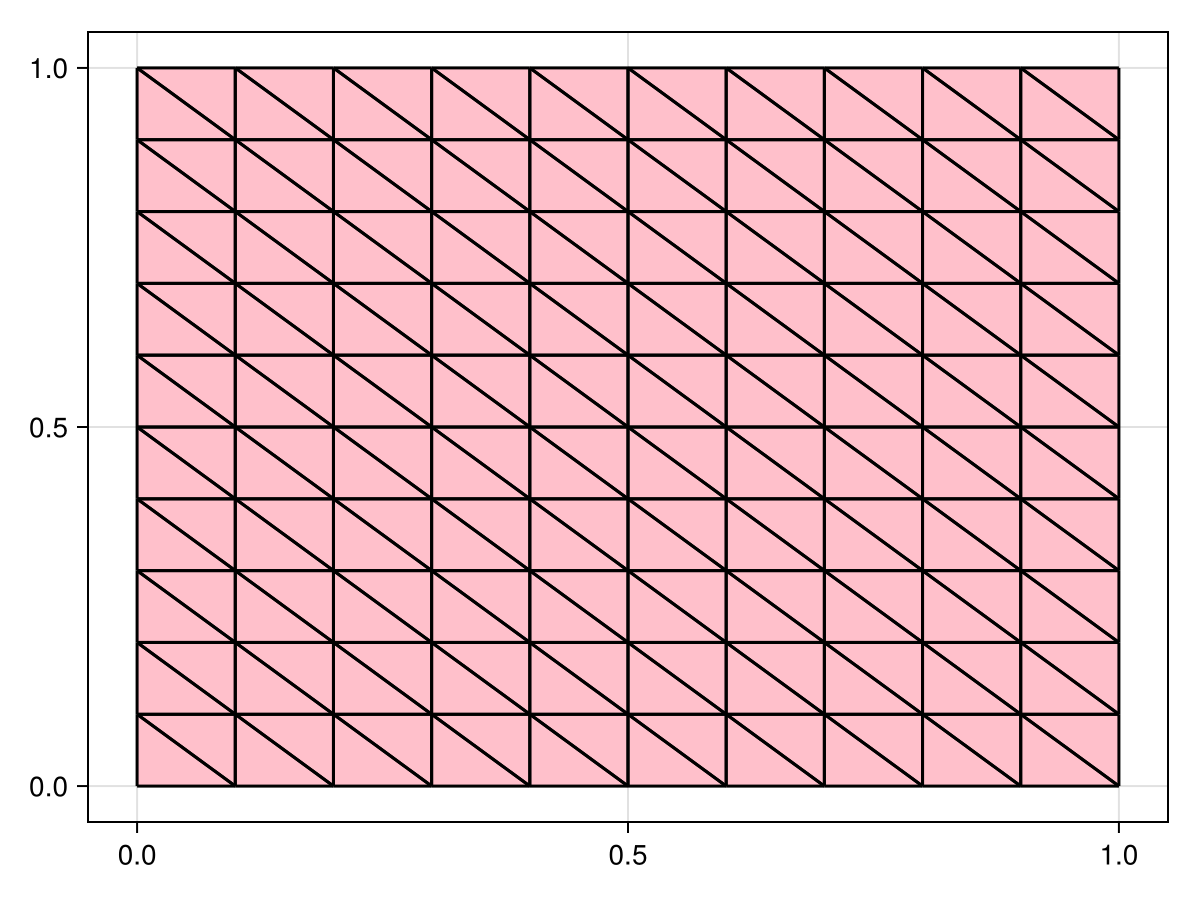

In [1]:
using Gridap
using GridapMakie
using CairoMakie

n = 10 # Number of elements in x and y for square mesh
domain = (0,1,0,1)
partition = (n, n)
model = CartesianDiscreteModel(domain, partition)
# Change to triangles
model = simplexify(model)
𝓣ₕ = Triangulation(model)
plt = plot(𝓣ₕ)
wireframe!(𝓣ₕ, color=:black)
plt

We manufacture the solution $u = \sin(2\pi x)\sin(\pi y)$ by choosing the
right hand side:

In [2]:
u(x) = sin(2*pi*x[1]) * sin(pi*x[2])
f(x) = 5 * pi^2 * u(x) # = -Δu

f (generic function with 1 method)

We consider the discrete space

$$
V_h = \{v_h\in H_0^1(\Omega): v_h|_K \in\mathbb{P}_k(K),\quad\forall K\in \mathcal{T}_h\}.
$$

This is achieved through the following with Gridap.jl:

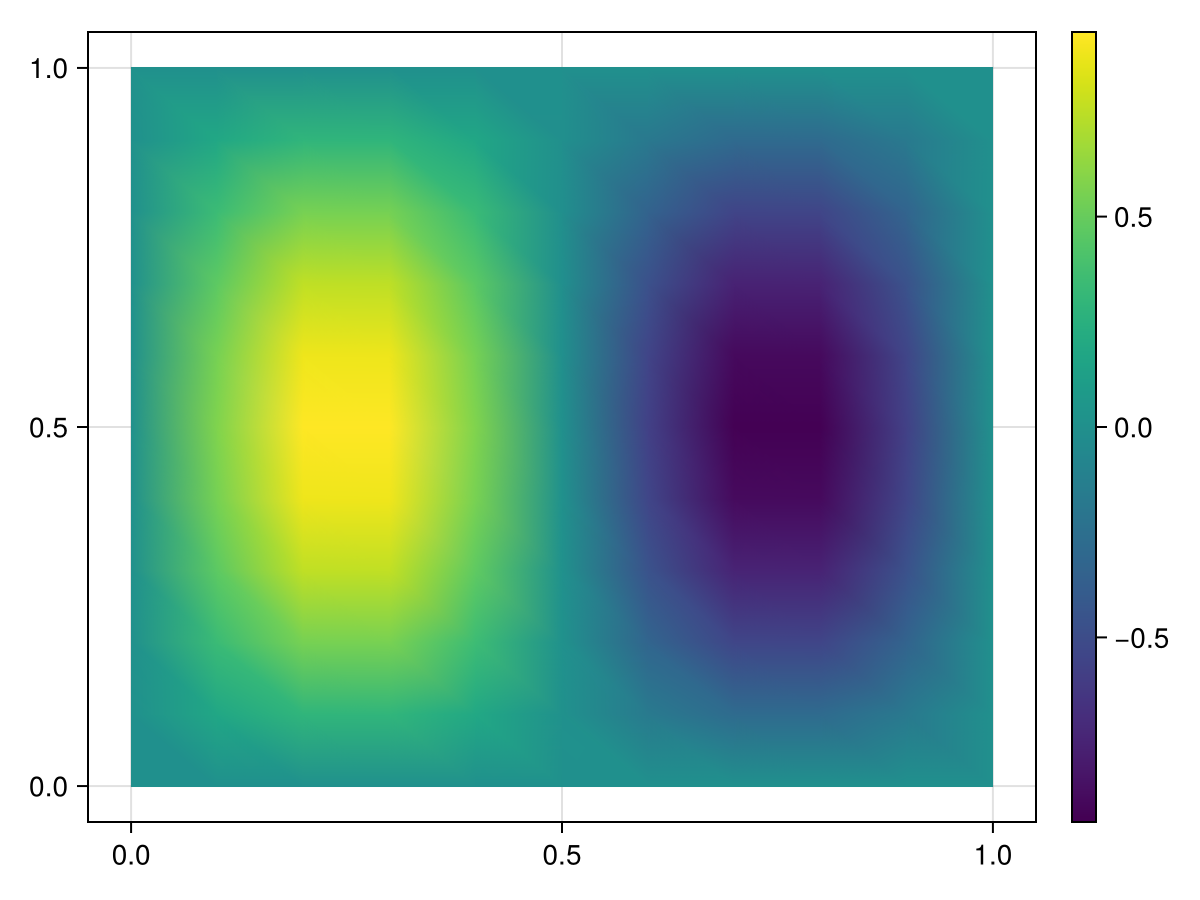

In [3]:
# Polynomial order
order = 1
degree = 2 * order + 2
dx = Measure(𝓣ₕ, degree)
reffe = ReferenceFE(lagrangian, Float64, order)
V0 = TestFESpace(model, reffe; conformity = :H1, dirichlet_tags = "boundary")
U = TrialFESpace(V0, u)
a(u, v) = ∫(∇(v) ⊙ ∇(u)) * dx
b(v) = ∫(v * f) * dx
op = AffineFEOperator(a, b, U, V0)
uh = solve(op)
fig_soln, _ , plt = plot(𝓣ₕ, uh, colormap=:viridis)
Colorbar(fig_soln[1,2], plt)
fig_soln

We can then build the fluxes $\sigma_{\mathrm{eq},h}$ and
$\sigma_{\mathrm{ave},h}$ via the following:

In [4]:
using EquilibratedFlux
σ_eq = build_equilibrated_flux(-∇(uh), f, model, order);
σ_ave = build_averaged_flux(-∇(uh), model);

First we calculate the estimators and the error using the fluxes and the
approximate solution $u_h$.

In [5]:
include("helpers.jl")

H1err² = L2_norm_squared(∇(u - uh), dx)
@show sqrt(sum(H1err²))
H1err_arr = sqrt.(getindex(H1err², 𝓣ₕ));

η_eq² = L2_norm_squared(σ_eq + ∇(uh), dx)
@show sqrt(sum(η_eq²))
ηeq_arr = sqrt.(getindex(η_eq², 𝓣ₕ));

η_ave² = L2_norm_squared(σ_ave + ∇(uh), dx)
@show sqrt(sum(η_ave²))
ηave_arr = sqrt.(getindex(η_ave², 𝓣ₕ));

sqrt(sum(H1err²)) = 0.8073549942018825
sqrt(sum(η_eq²)) = 0.841233933128969
sqrt(sum(η_ave²)) = 0.9656710082861283


Now we plot the estimators and errors restricted to each element (the full
code can be found in `helpers.jl`)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/6c4lt/src/scenes.jl:229


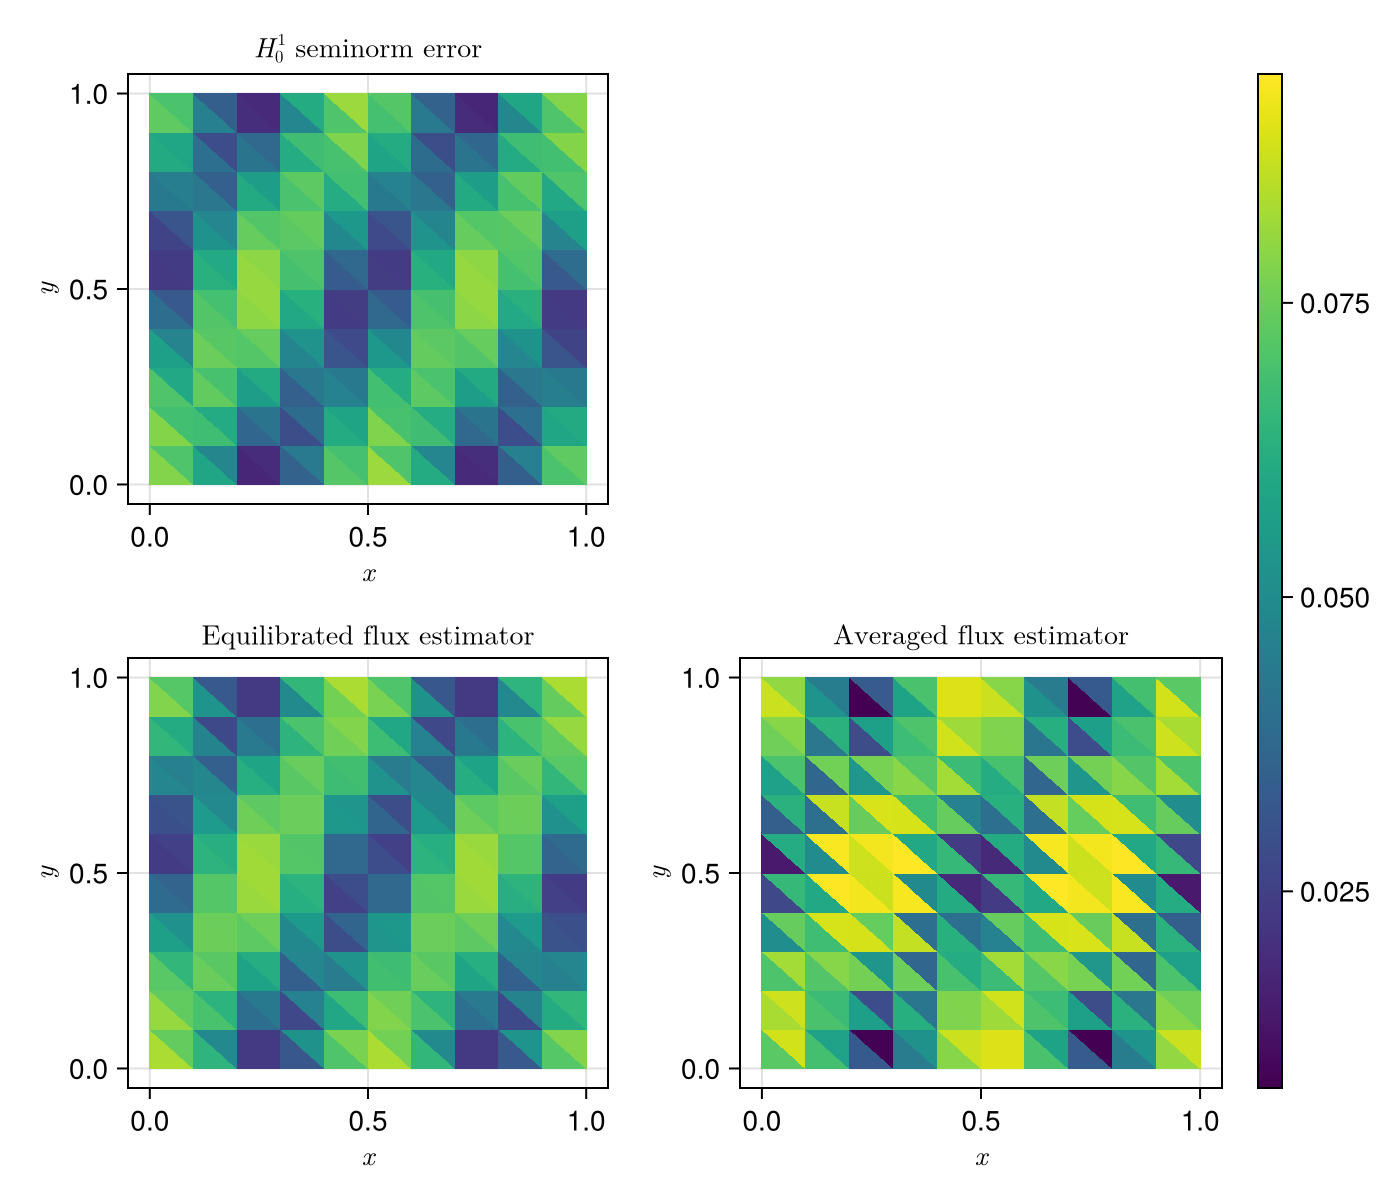

In [6]:
fig = plot_error_and_estimator(𝓣ₕ, ηave_arr, ηeq_arr, H1err_arr)

We see that both estimators provide a good cellwise approximation of the
error, but the one based on the equilibrated flux is closer visually. Next, we
consider the divergence error, i.e., how well the reconstructed object
satisfies $\nabla\cdot\sigma = \Pi_1 f$. In particular, in the following plot
we can see that the equilibrated flux estimator satisfies the divergence
constraint up to machine precision, but the flux based on averaging does not.

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/6c4lt/src/scenes.jl:229


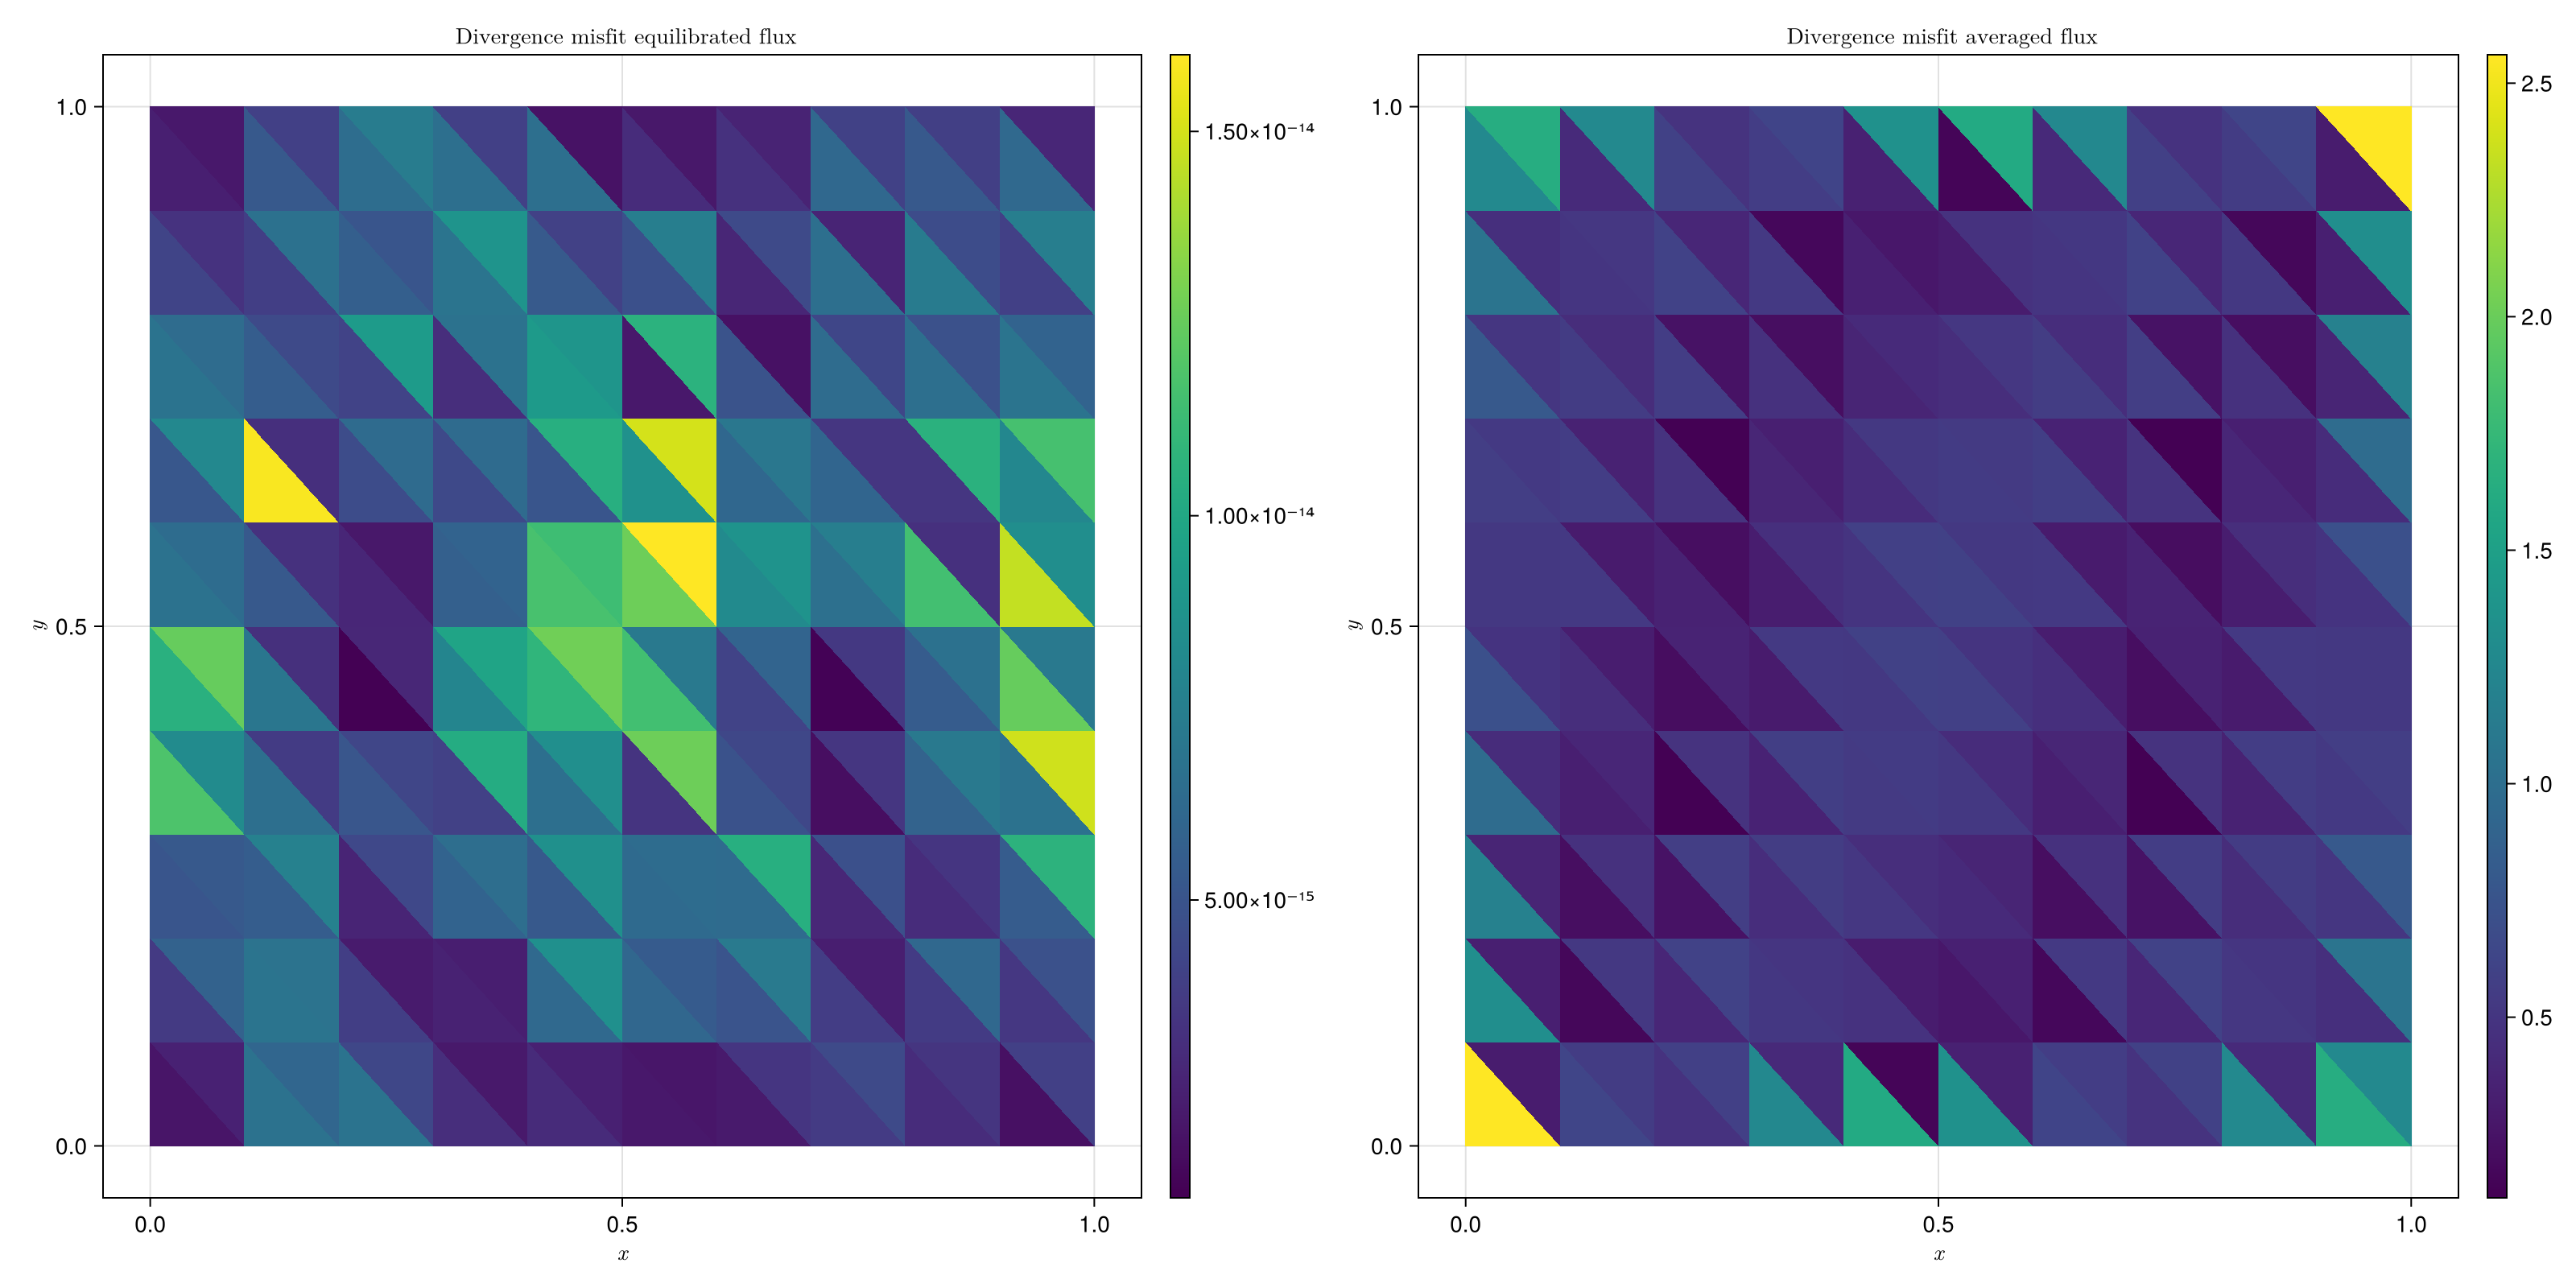

In [7]:
f_proj = L²_projection(model, reffe, f, dx)
eq_div  = L2_norm_squared(∇ ⋅ σ_eq - f_proj, dx)
ave_div = L2_norm_squared(∇ ⋅ σ_ave - f_proj, dx)
eq_div_vis = CellField(sqrt.(getindex(eq_div, 𝓣ₕ)), 𝓣ₕ)
ave_div_vis = CellField(sqrt.(getindex(ave_div, 𝓣ₕ)), 𝓣ₕ)
fig = plot_divergence_misfit(𝓣ₕ, eq_div_vis, ave_div_vis)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*